# Tensorflow tutorial for Convolutional Neural Networks - Classification

### CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

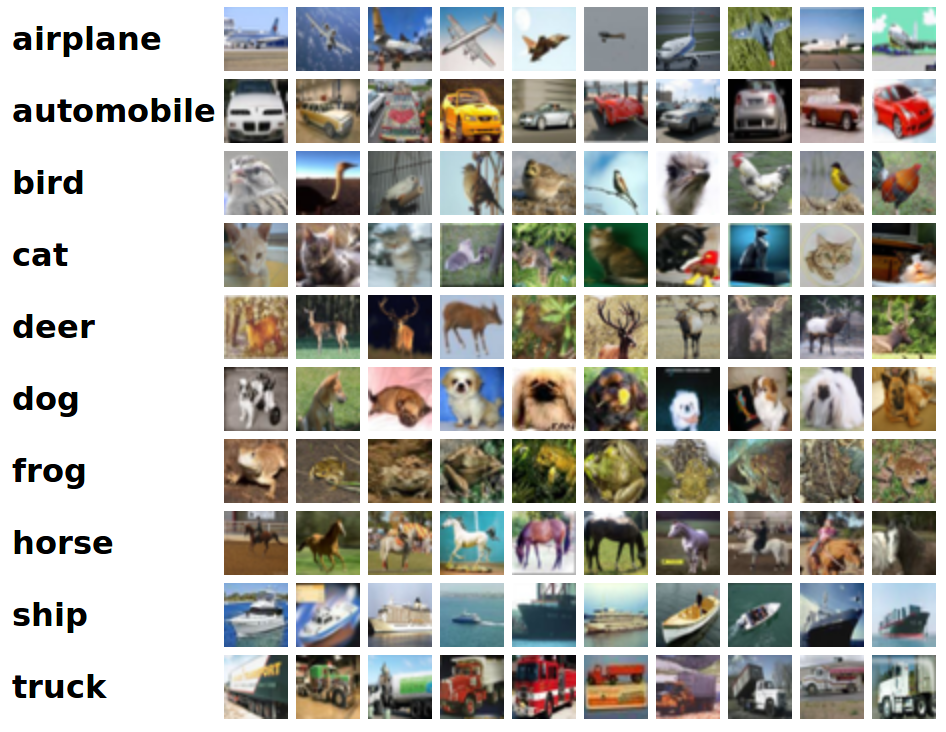

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import time
import sys
import os
import re
import tarfile
from six.moves import urllib
import zipfile
import pickle
os.environ['CUDA_VISIBLE_DEVICES']='2'

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf #<-------------

In [ ]:
#Tensorflow bite
hello = tf.constant('Hello, TensorFlow!')
var1 = tf.constant(5.85)
var2 = tf.constant([45.85,20,-85])
var3 = var2*var1
sess = tf.Session()
print(sess.run(hello))
print('---')
print(var3)
print('---')
print(sess.run(var3))
print('---')

### Download CIFAR10

In [ ]:
def _print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def maybe_download_and_extract(main_directory):
    cifar_10_directory = main_directory+"/cifar_10/"
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)

        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_10 = file_path
        file_path, _ = urllib.request.urlretrieve(url=url, filename=file_path, reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")

        os.rename(main_directory+"/cifar-10-batches-py", cifar_10_directory)
        os.remove(zip_cifar_10)

In [ ]:
data_dir = 'data_set'
maybe_download_and_extract(data_dir)

In [ ]:
sorted(os.listdir(data_dir+"/cifar_10"))

In [ ]:
import numpy as np
def get_data_set(name="train", cifar=10):
    x = None
    y = None
    l = None

    folder_name = "cifar_10"

    f = open('./data_set/'+folder_name+'/batches.meta', 'rb')
    datadict = pickle.load(f)
    f.close()
    l = datadict['label_names']

    if name is "train":
        for i in range(5):
            f = open('./data_set/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
            datadict = pickle.load(f)
            f.close()

            _X = datadict["data"]
            _Y = datadict['labels']

            _X = np.array(_X, dtype=float) / 255.0
            _X = _X.reshape([-1, 3, 32, 32])
            _X = _X.transpose([0, 2, 3, 1])
            _X = _X.reshape(-1, 32*32*3)

            if x is None:
                x = _X
                y = _Y
            else:
                x = np.concatenate((x, _X), axis=0)
                y = np.concatenate((y, _Y), axis=0)

    elif name is "test":
        f = open('./data_set/'+folder_name+'/test_batch', 'rb')
        datadict = pickle.load(f)
        f.close()

        x = datadict["data"]
        y = np.array(datadict['labels'])

        x = np.array(x, dtype=float) / 255.0
        x = x.reshape([-1, 3, 32, 32])
        x = x.transpose([0, 2, 3, 1])
        x = x.reshape(-1, 32*32*3)

    return x, y, l        

In [ ]:
train_x, train_y, train_l = get_data_set()
test_x, test_y, test_l = get_data_set("test")

In [ ]:
print('{}\n\n{}\n\n{}'.format(train_x, train_y, train_l))
print('-----')
print('{}\n\n{}\n\n{}'.format(train_x.shape, train_y.shape, len(train_l)))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def denorm_show(img_, label, n):
    img = img_.copy()
    img = (img*255).astype(np.uint8)
    img = img.reshape(-1,32,32,3)
    for _ in range(n):
        m = np.random.randint(0,img.shape[0],1)[0]
        plt.imshow(img[m])
        plt.title(test_l[label[m]])
        plt.show()

In [ ]:
denorm_show(train_x, train_y, 4)

### Network

In [ ]:
def model():
    _IMAGE_SIZE = 32
    _IMAGE_CHANNELS = 3
    _NUM_CLASSES = 10
    _RESHAPE_SIZE = 4*4*128 #2048

    with tf.name_scope('data'):
        x = tf.placeholder(tf.float32, shape=[None, _IMAGE_SIZE * _IMAGE_SIZE * _IMAGE_CHANNELS], name='Input')
        y = tf.placeholder(tf.float32, shape=[None,], name='Output')
        x_image = tf.reshape(x, [-1, _IMAGE_SIZE, _IMAGE_SIZE, _IMAGE_CHANNELS], name='images')

    def get_variable(name, shape, stddev):
        dtype = tf.float32
        var = variable(name, shape, tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
        return var

    def variable(name, shape, initializer):
        dtype = tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
        return var

    ##CONV
    with tf.variable_scope('conv1') as scope:
        kernel = get_variable('weights', shape=[5, 5, 3, 64], stddev=5e-2)
        conv = tf.nn.conv2d(x_image, kernel, [1, 1, 1, 1], padding='SAME')
        biases = variable('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)
    tf.summary.histogram('Convolution_layers/conv1', conv1)
    tf.summary.scalar('Convolution_layers/conv1', tf.nn.zero_fraction(conv1))

    #Local Response Normalization and POOL
    norm1 = tf.nn.lrn(conv1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    pool1 = tf.nn.max_pool(norm1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

    ##CONV
    with tf.variable_scope('conv2') as scope:
        kernel = get_variable('weights', shape=[5, 5, 64, 64], stddev=5e-2)
        conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = variable('biases', [64], tf.constant_initializer(0.1))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name)
    tf.summary.histogram('Convolution_layers/conv2', conv2)
    tf.summary.scalar('Convolution_layers/conv2', tf.nn.zero_fraction(conv2))

    #NORM and POOL
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    ##CONV
    with tf.variable_scope('conv3') as scope:
        kernel = get_variable('weights', shape=[3, 3, 64, 128], stddev=5e-2)
        conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
        biases = variable('biases', [128], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv3 = tf.nn.relu(pre_activation, name=scope.name)
    tf.summary.histogram('Convolution_layers/conv3', conv3)
    tf.summary.scalar('Convolution_layers/conv3', tf.nn.zero_fraction(conv3))

    ##CONV
    with tf.variable_scope('conv4') as scope:
        kernel = get_variable('weights', shape=[3, 3, 128, 128], stddev=5e-2)
        conv = tf.nn.conv2d(conv3, kernel, [1, 1, 1, 1], padding='SAME')
        biases = variable('biases', [128], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv4 = tf.nn.relu(pre_activation, name=scope.name)
    tf.summary.histogram('Convolution_layers/conv4', conv4)
    tf.summary.scalar('Convolution_layers/conv4', tf.nn.zero_fraction(conv4))

    ##CONV
    with tf.variable_scope('conv5') as scope:
        kernel = get_variable('weights', shape=[3, 3, 128, 128], stddev=5e-2)
        conv = tf.nn.conv2d(conv4, kernel, [1, 1, 1, 1], padding='SAME')
        biases = variable('biases', [128], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv5 = tf.nn.relu(pre_activation, name=scope.name)
    tf.summary.histogram('Convolution_layers/conv5', conv5)
    tf.summary.scalar('Convolution_layers/conv5', tf.nn.zero_fraction(conv5))

    #NORM and POOL
    norm3 = tf.nn.lrn(conv5, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm3')
    pool3 = tf.nn.max_pool(norm3, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool3')

    #FC
    with tf.variable_scope('fully_connected1') as scope:
        reshape = tf.reshape(pool3, [-1, _RESHAPE_SIZE])
        weights = get_variable('weights', shape=[_RESHAPE_SIZE, 384], stddev=0.04)
        biases = variable('biases', [384], tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)
    tf.summary.histogram('Fully_connected_layers/fc1', local3)
    tf.summary.scalar('Fully_connected_layers/fc1', tf.nn.zero_fraction(local3))

    #FC
    with tf.variable_scope('fully_connected2') as scope:
        weights = get_variable('weights', shape=[384, 192], stddev=0.04)
        biases = variable('biases', [192], tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
    tf.summary.histogram('Fully_connected_layers/fc2', local4)
    tf.summary.scalar('Fully_connected_layers/fc2', tf.nn.zero_fraction(local4))

    #OUTPUT
    with tf.variable_scope('output') as scope:
        weights = get_variable('weights', [192, _NUM_CLASSES], stddev=1 / 192.0)
        biases = variable('biases', [_NUM_CLASSES], tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
    tf.summary.histogram('Fully_connected_layers/output', softmax_linear)

    global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
    y_pred_cls = tf.argmax(softmax_linear, axis=1)

    return x, y, softmax_linear, global_step, y_pred_cls

In [ ]:
x, y, output, global_step, y_pred_cls = model()

In [ ]:
#Exploring the outputs of the network
print(x)
print(y)
print(output)
print(global_step)
print(y_pred_cls)

In [ ]:
model_vars = tf.trainable_variables()
for i in model_vars: print(i)

In [ ]:
model_vars = tf.trainable_variables()
import tensorflow.contrib.slim as slim
slim.model_analyzer.analyze_vars(model_vars, print_info=True)

### Loss

In [ ]:
def LOSS(logits, labels):
    """

    Add summary for "Loss" and "Loss/avg".
    Args:
      logits: Logits from inference().
      labels: Labels from distorted_inputs or inputs(). 1-D tensor
            of shape [batch_size]

    Returns:
      Loss tensor of type float.
    """
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.summary.scalar('LOSS', cross_entropy_mean)
    return cross_entropy_mean

In [ ]:
loss = LOSS(output, y)
print(loss)

### Optimizer

In [ ]:
global_step = tf.train.get_or_create_global_step()
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(loss, global_step=global_step)

### Accuracy

In [ ]:
correct_prediction = tf.equal(y_pred_cls, tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar("Accuracy/train", accuracy)

In [ ]:
#Merge all tensorboard and start session
_SAVE_PATH = 'tensorboard/cifar-10' #Where logs are going to be stored
merged = tf.summary.merge_all()
saver = tf.train.Saver()
sess = tf.Session()
train_writer = tf.summary.FileWriter(_SAVE_PATH, sess.graph)

### TRAIN

In [ ]:
try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=_SAVE_PATH)
    saver.restore(sess, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead.")
sess.run(tf.global_variables_initializer())

In [ ]:
def predict_test(show_confusion_matrix=False):
    '''
        Make prediction for all images in test_x
    '''
    i = 0
    predicted_class = np.zeros(shape=len(test_x), dtype=np.int)
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j]
        predicted_class[i:j] = sess.run(y_pred_cls, feed_dict={x: batch_xs, y: batch_ys})
        i = j

    correct = (test_y == predicted_class)*1.0
    acc = np.mean(correct)*100
    correct_numbers = np.sum(correct)
    print("Accuracy on Test-Set: {0:.2f}% ({1} / {2})".format(acc, int(correct_numbers), len(test_x)))

    if show_confusion_matrix is True:
        cm = confusion_matrix(y_true=np.argmax(test_y, axis=1), y_pred=predicted_class)
        for i in range(_CLASS_SIZE):
            class_name = "({}) {}".format(i, test_l[i])
            print(cm[i, :], class_name)
        class_numbers = [" ({0})".format(i) for i in range(_CLASS_SIZE)]
        print("".join(class_numbers))

    return acc

In [ ]:
_BATCH_SIZE = 128
batch_xs = test_x[:_BATCH_SIZE, :]
batch_ys = test_y[:_BATCH_SIZE]
predicted_class = sess.run(y_pred_cls, feed_dict={x: batch_xs})
print(predicted_class)
print(batch_ys)


In [ ]:
_IMG_SIZE = 32
_NUM_CHANNELS = 3
_BATCH_SIZE = 128
_CLASS_SIZE = 10
_ITERATION = 10000
_SAVE_PATH = "./tensorboard/cifar-10/"
for i in range(_ITERATION):
    randidx = np.random.randint(len(train_x), size=_BATCH_SIZE)
    batch_xs = train_x[randidx]
    batch_ys = train_y[randidx]

    start_time = time.time()
    i_global, _ = sess.run([global_step, optimizer], feed_dict={x: batch_xs, y: batch_ys})
    duration = time.time() - start_time

    if (i_global % 10 == 0) or (i == _ITERATION - 1):
        _loss, batch_acc = sess.run([loss, accuracy], feed_dict={x: batch_xs, y: batch_ys})
        msg = "Global Step: {0:>6}, accuracy: {1:>6.1%}, loss = {2:.2f} ({3:.1f} examples/sec, {4:.2f} sec/batch)"
        print(msg.format(i_global, batch_acc, _loss, _BATCH_SIZE / duration, duration))

    if (i_global % 100 == 0) or (i == _ITERATION - 1):
        data_merged, global_1 = sess.run([merged, global_step], feed_dict={x: batch_xs, y: batch_ys})
        acc = predict_test()

        summary = tf.Summary(value=[
            tf.Summary.Value(tag="Accuracy/test", simple_value=acc*100),
        ])
        train_writer.add_summary(data_merged, global_1)
        train_writer.add_summary(summary, global_1)

        saver.save(sess, save_path=_SAVE_PATH, global_step=global_step)
        print("Saved checkpoint.")
sess.close()

In [ ]:
#tensorboard --logdir tensorboard/cifar-10